In [1]:
# Import packages to use
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
# Define the file to explore
file='resumen_N100_Niter20000000_beta2.5_dt2.5e-07_lf1.0_stf50_Nsimstot1002_mul10.csv'

# Define the parameters for the simulation
N=100
beta=2.5
s=1.0
nu=-1/(beta+1)
dt=2.5e-7
Nsims=1002

# Import the data file
df=pd.read_csv(file, engine='python')
print(df.columns.tolist())
print('Theoretical exponent (nu)= %g'%nu)

['t', 'log_t', 'N_avg', 'std_N', 'log_N']
Theoretical exponent (nu)= -0.285714


In [16]:
# We account for the fact that there are 50 initial simulations without fusion
# Therefore we substract 50*dt from the time and create a new data frame
# We take the data from the 6-th index onwards to erase negative times
df50=df.copy()
df50['t']=df50['t']-50*dt
df50=df50[6:]
# Recalculate log(t)
df50['log_t']=np.log(df50['t'])

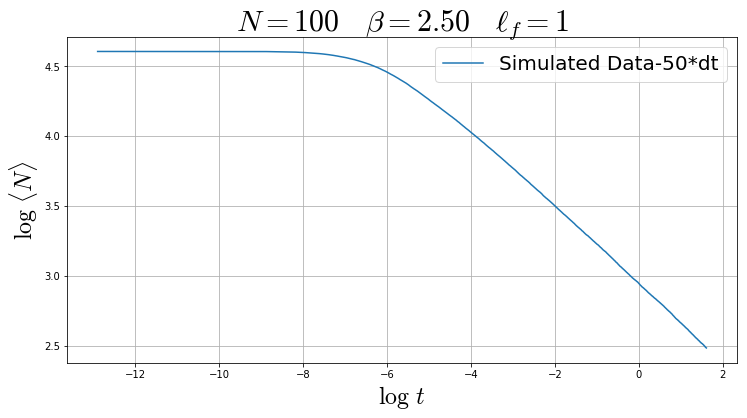

In [17]:
# Plot the entire log-data
# Plot the data 
plt.figure(figsize=(12,6))

plt.plot(df50.log_t,df50.log_N, label='Simulated Data-50*dt')

plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()

In [18]:
# Cut the data in order to analyze the last part
# The cut-value can be changed and will change the results
cut=-4
cut2=1
df_tail=df50[(df50['log_t']>cut) & (df50['log_t']<cut2)]

In [19]:
# Perform fit of the form y=ax+b
# Define function to calculate a,b,err_a,err_b
def regression(x,y,err_y):
    n=len(x)
    xiyi=np.sum(np.multiply(x,y))
    xi=np.sum(x)
    yj=np.sum(y)
    xi2=np.sum(np.square(x))
    xidyi=np.sum(np.multiply(x,err_y))
    dyj=np.sum(err_y)
    den=n*xi2-xi**2
    
    a=(n*xiyi-xi*yj)/den
    b=(xi2*yj-xi*xiyi)/den
    err_a=(n*xidyi-xi*dyj)/den
    err_b=(xi2*dyj-xi*xidyi)/den
    
    return a,b,err_a,err_b

In [20]:
xreg=df_tail['log_t']
yreg=df_tail['log_N']
y_err=np.divide(df_tail['std_N'],df_tail['N_avg'])

nu_res,intercept,err_nu,err_int=regression(xreg,yreg,y_err)
print('nu-exponent: %f'%nu_res)
print('nu-error: %f'%err_nu)
print('constant: %f'%intercept)
print('constant error: %f'%err_int)

nu-exponent: -0.277638
nu-error: 0.014802
constant: 2.945169
constant error: 0.121561


# LINEAR REGRESSION FOR MEAN VALUE

In [21]:
# Perform the linear regression for the asymptotic behaviour of the mean values
X=df_tail['log_t']
y=df_tail['log_N']

X = sm.add_constant(X)
model=sm.OLS(y,X)
results=model.fit()
nu_res=results.params[1]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_N   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.508e+09
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:27:54   Log-Likelihood:             4.6526e+06
No. Observations:             1079986   AIC:                        -9.305e+06
Df Residuals:                 1079984   BIC:                        -9.305e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9452   3.14e-06   9.39e+05      0.0

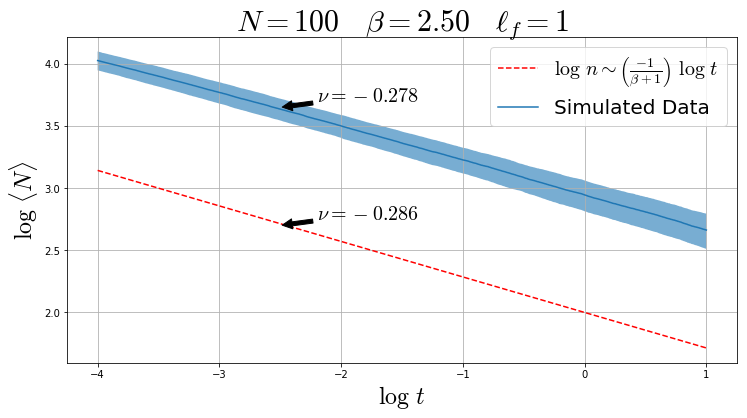

In [22]:
# Plot the partial data with the theoretical behaviour 
plt.figure(figsize=(12,6))

# Define the data for the theoretical behaviour comparison
xreg=np.linspace(min(df_tail.log_t),max(df_tail.log_t))
yreg=-(1.0/(beta+1.0))*xreg+2
plt.annotate(r'$\nu=%.3f$'%nu, 
             xy=(-2.5, 2.7),
             xytext=(-2.2,2.75),
             xycoords='data',
             arrowprops=dict(arrowstyle="simple",facecolor='black'),
             fontsize=20)

ecu=r'$\log \ n \sim  \left( \frac{-1}{\beta+1} \right) \ \log \ t$'
plt.plot(xreg,yreg,'--',c='red',label=ecu)

plt.plot(df_tail.log_t,df_tail.log_N,label='Simulated Data')

upper=np.log(df_tail['N_avg']+df_tail['std_N'])
lower=np.log(df_tail['N_avg']-df_tail['std_N'])
plt.fill_between(df_tail.log_t,upper,lower,alpha=0.6)
plt.annotate(r'$\nu=%.3f$'%nu_res, 
             xy=(-2.5, 3.65),
             xytext=(-2.2,3.7),
             xycoords='data',
             arrowprops=dict(arrowstyle="simple",facecolor='black'),
             fontsize=20)


plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20,loc=1)
plt.show()
plt.close()

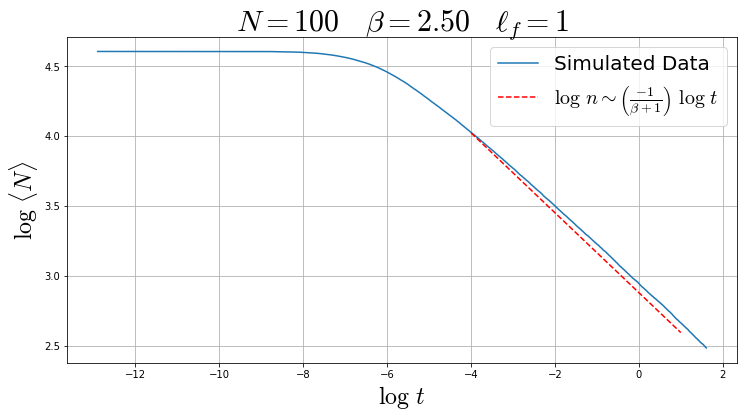

In [23]:
plt.figure(figsize=(12,6))

xreg=np.linspace(min(df_tail.log_t),max(df_tail.log_t))
yreg=-(1.0/(beta+1.0))*xreg+2.88

plt.plot(df.log_t,df.log_N,label='Simulated Data')

ecu=r'$\log \ n \sim  \left( \frac{-1}{\beta+1} \right) \ \log \ t$'
plt.plot(xreg,yreg,'--',c='red',label=ecu)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()

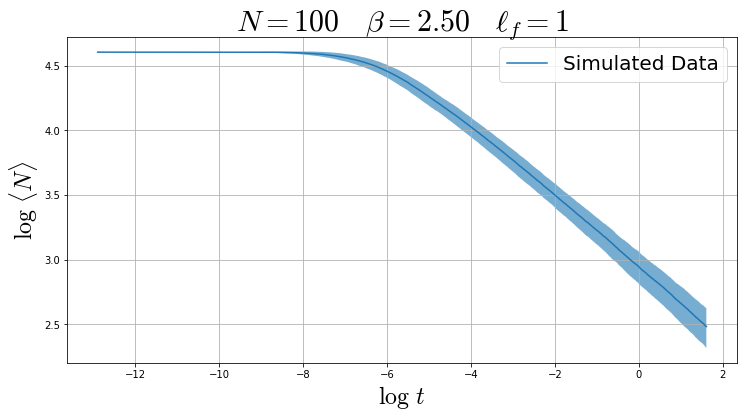

In [24]:
plt.figure(figsize=(12,6))

plt.plot(df.log_t,df.log_N,label='Simulated Data')

upper=np.log(df['N_avg']+df['std_N'])
lower=np.log(df['N_avg']-df['std_N'])
plt.fill_between(df.log_t,upper,lower,alpha=0.6)

plt.title(r'$N=%i \quad \beta=%.2f \quad \ell_f=%g$'%(N,beta,s),fontsize=30)
plt.xlabel(r'$\log \ t$',fontsize=24)
plt.ylabel(r'$\log \ \langle N \rangle $',fontsize=24)

plt.grid(zorder=3)
plt.legend(fontsize=20)
plt.show()
plt.close()